# Project Storm: Hurricane Occurrence Prediction Model (Florida)

This notebook trains a model to predict the monthly probability of hurricane occurrence in **Florida counties** based on processed climate variables.

**Data Requirements:**
1.  `county_monthly_climate_variables_FL.csv` (or `.parquet`): Output from the state-filtered `process_climate_data_FL.py` script.
2.  `county_events.csv`: Original full event list to extract Florida hurricane occurrences.
3.  County Definitions (Optional, for context): `data/counties/2024_counties.txt`

In [46]:
# --- Cell 2: Code (Setup & Configuration) ---

import os
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb # Or import xgboost
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, auc, ConfusionMatrixDisplay
# from imblearn.over_sampling import SMOTE # Optional
import matplotlib.pyplot as plt
import logging
import datetime # Import datetime to potentially get current year

# --- Configuration ---
# --- Input Data Paths ---
CLIMATE_FILE = "../output/processed_climate/county_monthly_climate_variables_12.parquet" # Use the FL-specific file
# Or: CLIMATE_FILE = "../output/processed_climate/county_monthly_climate_variables_12.csv"
EVENTS_FILE = "../output/final/county_events.csv"
COUNTIES_DEF_FILE = "../data/counties/2024_counties.txt"

# --- Model & Target Setup ---
TARGET_EVENT_TYPE = 'hurricane'
TARGET_STATE_FIPS = '12' # Florida

# --- Feature Engineering Parameters ---
LAG_MONTHS = [1, 3, 6]

# --- Train/Test Split Parameters ---
TRAIN_YEAR_END = 2021     # Train on data up to (and including) this year
TEST_YEAR_START = 2022    # Start test set from this year
# --- !! NEW: Define the last year for which we have TRUE event data !! ---
# Adjust this if your event data stops earlier/later than 2024
MAX_EVALUATION_YEAR = 2024

# --- Output Paths ---
MODEL_OUTPUT_DIR = "../output/models"
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
SCALER_PATH = os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_FL_scaler.joblib")
MODEL_PATH = os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_FL_lgbm_model.joblib")

# --- Other Parameters ---
RANDOM_STATE = 42

# --- Setup Logger ---
# (Logger setup remains the same)
LOG_FILE = "../logs/model_training_FL_log.log"
logger = logging.getLogger("ModelTrainingLoggerFL")
logger.setLevel(logging.DEBUG)
if not logger.handlers:
    fh = logging.FileHandler(LOG_FILE, mode='w'); fh.setLevel(logging.DEBUG); logger.addHandler(fh)
    sh = logging.StreamHandler(); sh.setLevel(logging.INFO); logger.addHandler(sh)
    # Add formatters if desired
logger.info("--- Model Training Notebook Started (Florida Hurricanes) ---")
logger.info(f"Configuration:")
logger.info(f"  Climate Data File: {CLIMATE_FILE}")
logger.info(f"  Events Data File: {EVENTS_FILE}")
logger.info(f"  Target Event: {TARGET_EVENT_TYPE}")
logger.info(f"  Target State FIPS: {TARGET_STATE_FIPS}")
logger.info(f"  Lag Months: {LAG_MONTHS}")
logger.info(f"  Train Year End: {TRAIN_YEAR_END}")
logger.info(f"  Test Year Start: {TEST_YEAR_START}")
logger.info(f"  Max Evaluation Year: {MAX_EVALUATION_YEAR}") # Log new parameter


# --- Get Florida County GEOIDs ---
# (This section remains the same as before)
fl_geoids = []
try:
    df_county_defs = pd.read_csv(COUNTIES_DEF_FILE, delimiter='\t', dtype={'GEOID': str, 'USPS': str})
    df_county_defs.columns = df_county_defs.columns.str.strip()
    if 'USPS' not in df_county_defs.columns: raise ValueError("'USPS' column not found.")
    fl_geoids = df_county_defs[df_county_defs['USPS'] == 'FL']['GEOID'].astype(str).str.strip().str.zfill(5).unique().tolist()
    if not fl_geoids:
        logger.warning("No GEOIDs found using USPS='FL'. Trying State FIPS.")
        if 'STATEFP' in df_county_defs.columns:
             fl_geoids = df_county_defs[df_county_defs['STATEFP'] == TARGET_STATE_FIPS]['GEOID'].astype(str).str.strip().str.zfill(5).unique().tolist()
    if not fl_geoids: raise ValueError(f"No Florida GEOIDs found.")
    logger.info(f"Identified {len(fl_geoids)} Florida county GEOIDs.")
except Exception as e:
    logger.exception(f"Failed to load Florida county GEOIDs: {e}")
    raise

# --- Define TARGET_VARIABLES dictionary needed later ---

TARGET_VARIABLES = {
    'tasmax': 'Max Temp',
    'huss': 'Spec Humid',
    'hfss': 'Sens Heat Flux',
    'pr': 'Precip',
    # 'uas': 'U Wind',  # REMOVED
    # 'vas': 'V Wind',  # REMOVED
    'psl': 'Sea Level Press',
    'mrsos': 'Soil Moisture',
    'orog': 'Altitude',     # ADDED
    'sfcWind': 'Wind Speed' # ADDED
}

# ... (Rest of Cell #2 remains the same) ...
logger.debug(f"TARGET_VARIABLES defined: {TARGET_VARIABLES}")

[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - --- Model Training Notebook Started (Florida Hurricanes) ---
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Configuration:
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL -   Climate Data File: ../output/processed_climate/county_monthly_climate_variables_12.parquet
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL -   Events Data File: ../output/final/county_events.csv
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL -   Target Event: hurricane
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL -   Target State FIPS: 12
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL -   Lag Months: [1, 3, 6]
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL -   Train Year End: 2021
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL -   Test Year Start: 2022
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL -   Max Evaluation Year: 2024
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Identified 67 Florida county GEOIDs.


In [47]:
# --- Load Data ---
logger.info("Loading processed climate (FL only) and full event data...")
if not fl_geoids:
    logger.error("Florida GEOID list is empty. Cannot proceed.")
    raise ValueError("Florida GEOID list empty.")

try:
    # Load the climate data already processed for Florida
    if CLIMATE_FILE.endswith(".parquet"):
        df_climate_fl = pd.read_parquet(CLIMATE_FILE)
    else:
        df_climate_fl = pd.read_csv(CLIMATE_FILE, parse_dates=['time'])
    # Ensure geoid is string
    df_climate_fl['county_geoid'] = df_climate_fl['county_geoid'].astype(str).str.zfill(5)
    logger.info(f"Loaded Florida climate data shape: {df_climate_fl.shape}")

    # Load full events file
    df_events = pd.read_csv(EVENTS_FILE, parse_dates=['first_impact_dt'], dtype={'county_geoid': str})
    df_events['county_geoid'] = df_events['county_geoid'].astype(str).str.zfill(5) # Ensure consistent padding
    logger.info(f"Loaded full events data shape: {df_events.shape}")

except Exception as e:
    logger.exception(f"Failed to load data: {e}")
    raise e

[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Loading processed climate (FL only) and full event data...
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Loaded Florida climate data shape: (16884, 10)
C:\Users\60864\AppData\Local\Temp\ipykernel_32248\795221960.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_events = pd.read_csv(EVENTS_FILE, parse_dates=['first_impact_dt'], dtype={'county_geoid': str})
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Loaded full events data shape: (209023, 4)


In [48]:
# --- Prepare Target Variable (Monthly Occurrence for FL Hurricanes) ---
logger.info(f"Preparing target variable: {TARGET_EVENT_TYPE}_occurred for Florida")
target_col = f'{TARGET_EVENT_TYPE}_occurred'
try:
    # Filter events for TARGET_EVENT_TYPE and Florida counties BEFORE aggregation
    df_events_fl_hurr = df_events[
        (df_events['event_type'] == TARGET_EVENT_TYPE) &
        (df_events['county_geoid'].isin(fl_geoids))
    ].copy()
    logger.info(f"Found {len(df_events_fl_hurr)} Florida hurricane event records.")

    if df_events_fl_hurr.empty:
         logger.warning(f"No {TARGET_EVENT_TYPE} events found for Florida counties. Target variable will be all zeros.")
         # Create empty occurrence df to ensure merge works but target is all 0
         df_monthly_occurrence_fl = pd.DataFrame(columns=['county_geoid', 'time', target_col])

    else:
        df_events_fl_hurr['year_month'] = df_events_fl_hurr['first_impact_dt'].dt.to_period('M')
        df_monthly_counts_fl = df_events_fl_hurr.groupby(
            ['county_geoid', 'year_month']
        ).size().reset_index(name='event_count')

        # Create binary occurrence flag
        df_monthly_occurrence_fl = df_monthly_counts_fl[['county_geoid', 'year_month']].drop_duplicates()
        df_monthly_occurrence_fl[target_col] = 1

        # Convert Period to timestamp (start of month) then date
        df_monthly_occurrence_fl['time'] = df_monthly_occurrence_fl['year_month'].dt.to_timestamp().dt.normalize()
        df_monthly_occurrence_fl['time'] = pd.to_datetime(df_monthly_occurrence_fl['time'])

    logger.info(f"Created monthly occurrence data for {len(df_monthly_occurrence_fl)} FL county-month instances.")
except Exception as e:
     logger.exception(f"Failed to prepare target variable: {e}")
     raise e

[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Preparing target variable: hurricane_occurred for Florida
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Found 3778 Florida hurricane event records.
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Created monthly occurrence data for 3634 FL county-month instances.


In [49]:
# --- Cell 5: Feature Engineering & Merging (Handling Fixed Vars) ---
logger.info("Starting feature engineering and merging for Florida...")
try:
    # --- Input Checks ---
    if 'df_climate_fl' not in locals() or df_climate_fl.empty: raise ValueError("df_climate_fl missing or empty.")
    if 'df_monthly_occurrence_fl' not in locals(): raise NameError("df_monthly_occurrence_fl not defined.")
    if 'fl_geoids' not in locals() or not fl_geoids: raise ValueError("fl_geoids list missing or empty.")
    if target_col not in df_monthly_occurrence_fl.columns and not df_monthly_occurrence_fl.empty:
        logger.warning(f"Target column '{target_col}' missing, assuming 0.")
    # --- End Checks ---

    df_climate_fl['time'] = pd.to_datetime(df_climate_fl['time'])

    # --- Identify Variable Types ---
    # Assume 'Altitude' is the only fixed variable based on TARGET_VARIABLES definition
    # If other fixed variables exist, add their standard names here
    fixed_var_names = ['Altitude']
    # Derive climate vars from columns, exclude keys and known fixed vars to get time-varying list
    known_non_climate_cols = ['county_geoid', 'time']
    all_climate_cols = [col for col in df_climate_fl.columns if col not in known_non_climate_cols]
    time_varying_climate_vars = [col for col in all_climate_cols if col not in fixed_var_names]
    fixed_climate_vars = [col for col in all_climate_cols if col in fixed_var_names]
    logger.info(f"Identified Time-Varying Vars: {time_varying_climate_vars}")
    logger.info(f"Identified Fixed Vars: {fixed_climate_vars}")
    # --- End Variable Type Identification ---

    # Create full index
    all_fl_counties = df_climate_fl['county_geoid'].unique()
    min_time, max_time = df_climate_fl['time'].min(), df_climate_fl['time'].max()
    if pd.isna(min_time) or pd.isna(max_time): raise ValueError("Climate data invalid time range.")
    all_times = pd.date_range(min_time, max_time, freq='MS')
    full_index = pd.MultiIndex.from_product([all_fl_counties, all_times], names=['county_geoid', 'time'])
    df_merged_fl = pd.DataFrame(index=full_index).reset_index()
    logger.debug(f"Created full FL index shape: {df_merged_fl.shape}")

    # Merge climate data
    df_merged_fl = pd.merge(df_merged_fl, df_climate_fl, on=['county_geoid', 'time'], how='left')
    # Merge event occurrence data
    if target_col not in df_monthly_occurrence_fl.columns and not df_monthly_occurrence_fl.empty:
        df_merged_fl[target_col] = 0 # Assign 0 if column never created (no events)
    elif not df_monthly_occurrence_fl.empty:
        df_merged_fl = pd.merge(df_merged_fl, df_monthly_occurrence_fl[['county_geoid', 'time', target_col]], on=['county_geoid', 'time'], how='left')
        df_merged_fl[target_col].fillna(0, inplace=True)
    else: # If df_monthly_occurrence_fl was empty
         df_merged_fl[target_col] = 0
    df_merged_fl[target_col] = df_merged_fl[target_col].astype(int)
    logger.debug(f"Shape after merging: {df_merged_fl.shape}")

    # Impute NaNs - Apply separately to time-varying and fixed if needed
    logger.info(f"Imputing NaNs using ffill/bfill per county (on time-varying vars).")
    df_merged_fl.sort_values(by=['county_geoid', 'time'], inplace=True)
    if time_varying_climate_vars: # Only apply if list is not empty
        df_merged_fl[time_varying_climate_vars] = df_merged_fl.groupby('county_geoid')[time_varying_climate_vars].ffill().bfill()
    # Handle NaNs in fixed variables (e.g., Altitude) - mean/median imputation or drop row?
    if fixed_climate_vars:
        for fixed_var in fixed_climate_vars:
            if df_merged_fl[fixed_var].isnull().any():
                 median_val = df_merged_fl[fixed_var].median() # Use median for robustness
                 logger.warning(f"NaNs found in fixed variable '{fixed_var}'. Imputing with median ({median_val:.2f}).")
                 df_merged_fl[fixed_var].fillna(median_val, inplace=True)

    # Check remaining NaNs in ALL climate vars used as features
    check_nan_cols = time_varying_climate_vars + fixed_climate_vars
    remaining_nans = df_merged_fl[check_nan_cols].isnull().sum()
    if remaining_nans.sum() > 0:
         logger.warning(f"NaNs remaining after imputation:\n{remaining_nans[remaining_nans > 0]}")
         logger.warning("Dropping rows with any remaining NaNs in climate variables.")
         df_merged_fl.dropna(subset=check_nan_cols, inplace=True) # Drop rows if imputation failed

    # Create Lagged Variables ONLY for time-varying ones
    logger.info(f"Creating lagged features for months: {LAG_MONTHS} (Time-Varying only)")
    lag_cols = []
    if time_varying_climate_vars:
        for lag in LAG_MONTHS:
            for var in time_varying_climate_vars: # Loop through time-varying only
                lag_col_name = f'{var}_lag{lag}'
                df_merged_fl[lag_col_name] = df_merged_fl.groupby('county_geoid')[var].shift(lag)
                lag_cols.append(lag_col_name)
    else:
         logger.warning("No time-varying climate variables identified to create lags for.")


    # Create Time Features
    df_merged_fl['month'] = df_merged_fl['time'].dt.month
    df_merged_fl['month_sin'] = np.sin(2 * np.pi * df_merged_fl['month']/12)
    df_merged_fl['month_cos'] = np.cos(2 * np.pi * df_merged_fl['month']/12)
    df_merged_fl['year'] = df_merged_fl['time'].dt.year

    # Drop rows with NaNs introduced by lagging
    logger.info(f"Dropping rows with NaNs created by lagging.")
    # Ensure lag_cols only contains columns that actually exist before dropping
    lag_cols_exist = [col for col in lag_cols if col in df_merged_fl.columns]
    if lag_cols_exist:
        df_merged_fl.dropna(subset=lag_cols_exist, inplace=True)
    logger.info(f"Shape after dropping lag NaNs: {df_merged_fl.shape}")
    if df_merged_fl.empty: raise ValueError("DataFrame is empty after dropping lag NaNs.")

    # Define features (X) and target (y)
    # Include: time-varying vars + their lags + fixed vars + time features
    feature_cols = time_varying_climate_vars + lag_cols_exist + fixed_climate_vars + ['month_sin', 'month_cos']
    # Ensure all selected feature columns exist
    feature_cols = [col for col in feature_cols if col in df_merged_fl.columns]

    X = df_merged_fl[feature_cols]
    y = df_merged_fl[target_col]
    logger.info(f"Prepared X ({X.shape}) and y ({y.shape}) for Florida")
    logger.debug(f"Final feature columns: {X.columns.tolist()}")

except Exception as e:
    logger.exception(f"Failed during feature engineering/merging: {e}")
    raise e

[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Starting feature engineering and merging for Florida...
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Identified Time-Varying Vars: ['Max Temp', 'Spec Humid', 'Sens Heat Flux', 'Precip', 'Sea Level Press', 'Soil Moisture', 'Wind Speed']
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Identified Fixed Vars: ['Altitude']
C:\Users\60864\AppData\Local\Temp\ipykernel_32248\476533719.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged_fl[target_col].fillna(0

In [50]:
# --- Cell 6: Split Data (Temporal Split - CORRECTED HISTORICAL) ---

# --- Determine Data Range ---
try:
    if 'df_merged_fl' not in locals() or df_merged_fl.empty: raise ValueError("'df_merged_fl' missing or empty.")
    if 'year' not in df_merged_fl.columns: raise ValueError("'year' column missing.")

    min_data_year = int(df_merged_fl['year'].min()) # Ensure int
    max_data_year = int(df_merged_fl['year'].max()) # Ensure int
    logger.info(f"Available data range in merged df: {min_data_year} to {max_data_year}")

except Exception as e:
    logger.exception(f"Error determining data range: {e}")
    raise e

# --- Validate Configured Split Years against Data Range ---
if TRAIN_YEAR_END < min_data_year: raise ValueError(f"TRAIN_YEAR_END ({TRAIN_YEAR_END}) is before min data year ({min_data_year}).")
if TEST_YEAR_START > MAX_EVALUATION_YEAR: raise ValueError(f"TEST_YEAR_START ({TEST_YEAR_START}) is after MAX_EVALUATION_YEAR ({MAX_EVALUATION_YEAR}). No historical test period possible.")
if TRAIN_YEAR_END >= TEST_YEAR_START: raise ValueError(f"TRAIN_YEAR_END ({TRAIN_YEAR_END}) must be < TEST_YEAR_START ({TEST_YEAR_START}).")

# Determine the actual last year available for testing (cannot exceed known events or climate data)
actual_max_test_year = min(max_data_year, MAX_EVALUATION_YEAR)
logger.info(f"Train period: <= {TRAIN_YEAR_END}")
logger.info(f"Test period: {TEST_YEAR_START} to {actual_max_test_year}")
# Prediction period will be years > actual_max_test_year up to max_data_year

try:
    # --- Input Checks ---
    if 'X' not in locals() or 'y' not in locals(): raise NameError("Variables 'X' and 'y' not defined.")
    if X.empty or y.empty: raise ValueError("Feature matrix 'X' or target vector 'y' is empty.")
    # --- End Input Checks ---

    # Create masks based on CORRECTED historical range
    train_mask = df_merged_fl['year'] <= TRAIN_YEAR_END
    test_mask = (df_merged_fl['year'] >= TEST_YEAR_START) & (df_merged_fl['year'] <= actual_max_test_year) # Use actual max test year

    X_train = X[train_mask]
    y_train = y[train_mask]

    # Create test sets
    if not test_mask.any():
         logger.warning(f"No test data found for years >= {TEST_YEAR_START} and <= {actual_max_test_year}. Evaluation will be skipped.")
         X_test = pd.DataFrame(columns=X.columns)
         y_test = pd.Series(dtype=y.dtype, name=y.name)
         test_identifiers = pd.DataFrame(columns=['county_geoid', 'time'])
         test_event_rate_str = "N/A (empty test set)"
    else:
         X_test = X[test_mask]
         y_test = y[test_mask]
         test_identifiers = df_merged_fl.loc[test_mask, ['county_geoid', 'time']]
         test_event_rate = y_test.mean()
         test_event_rate_str = f"{test_event_rate:.4f}" if not pd.isna(test_event_rate) else "N/A"

    # Check if train split is valid
    if not train_mask.any():
        logger.error("No training data selected based on TRAIN_YEAR_END.")
        raise ValueError("No training data selected.")
    if y_train.nunique() < 2:
        logger.warning("Training data contains only one class!")

    # Logging for train/test sets
    train_event_rate = y_train.mean()
    logger.info(f"Train set shape: {X_train.shape}, Year range: {min_data_year}-{TRAIN_YEAR_END}, Event rate: {train_event_rate:.4f}")
    logger.info(f"Test set shape: {X_test.shape}, Year range: {TEST_YEAR_START}-{actual_max_test_year}, Event rate: {test_event_rate_str}")


    # --- Store Future Climate Data (Years > MAX_EVALUATION_YEAR) ---
    # Identify data beyond the historical evaluation period
    future_mask = df_merged_fl['year'] > actual_max_test_year
    if future_mask.any():
        X_future = X[future_mask]
        future_identifiers = df_merged_fl.loc[future_mask, ['county_geoid', 'time']]
        future_min_year = df_merged_fl.loc[future_mask, 'year'].min()
        future_max_year = df_merged_fl.loc[future_mask, 'year'].max()
        logger.info(f"Separated future climate data for prediction ({len(X_future)} rows, years {future_min_year}-{future_max_year}).")
    else:
        logger.info(f"No future climate data found beyond year {actual_max_test_year}.")
        X_future = pd.DataFrame(columns=X.columns) # Empty dataframe

except NameError as ne:
     logger.exception(f"A required variable is missing: {ne}")
     raise ne
except ValueError as ve:
     logger.exception(f"ValueError during data splitting: {ve}")
     raise ve
except Exception as e:
     logger.exception(f"An unexpected error occurred during data splitting: {e}")
     raise e

[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Available data range in merged df: 2015 to 2035
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Train period: <= 2021
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Test period: 2022 to 2024
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Train set shape: (5226, 31), Year range: 2015-2021, Event rate: 0.0354
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Test set shape: (2412, 31), Year range: 2022-2024, Event rate: 0.0373
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Separated future climate data for prediction (8844 rows, years 2025-2035).


In [51]:
# --- Cell 7: Scale Features ---
logger.info("Scaling features using StandardScaler...")
try:
    if 'X_train' not in locals() or 'X_test' not in locals():
         raise NameError("Training or testing features (X_train, X_test) not defined from previous cell.")
    if X_train.empty:
        raise ValueError("X_train is empty, cannot fit scaler.")

    scaler = StandardScaler()
    # Fit scaler ONLY on training data
    X_train_scaled = scaler.fit_transform(X_train)
    # Transform test data using the SAME fitted scaler
    # Handle empty test set case
    X_test_scaled = scaler.transform(X_test) if not X_test.empty else np.array([]).reshape(0, X_train.shape[1])

    logger.info("Features scaled.")
    logger.debug(f"X_train_scaled shape: {X_train_scaled.shape}")
    logger.debug(f"X_test_scaled shape: {X_test_scaled.shape}")


    # Save the scaler
    joblib.dump(scaler, SCALER_PATH)
    logger.info(f"Scaler saved to {SCALER_PATH}")

except NameError as ne:
    logger.exception(f"Missing variable for scaling: {ne}")
    raise ne
except ValueError as ve:
     logger.exception(f"ValueError during scaling: {ve}")
     raise ve
except Exception as e:
    logger.exception(f"Failed during feature scaling: {e}")
    raise e

[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Scaling features using StandardScaler...
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Features scaled.
[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Scaler saved to ../output/models\hurricane_FL_scaler.joblib


In [52]:
# --- Cell 8: Handle Imbalance (Example: using class_weight) ---
# Determine if class weights should be used based on training data imbalance
try:
    if 'y_train' not in locals(): raise NameError("y_train not defined.")
    train_event_rate = y_train.mean()
    # Set use_class_weight to 'balanced' if event rate is low (e.g., <10%) or high (>90%)
    use_class_weight = 'balanced' if (train_event_rate < 0.1 or train_event_rate > 0.9) else None
    logger.info(f"Based on training event rate ({train_event_rate:.4f}), setting class_weight: {use_class_weight}")
except NameError as ne:
     logger.exception(f"y_train missing, cannot determine class weight: {ne}")
     use_class_weight = None # Default to None if y_train isn't available
     raise ne
except Exception as e:
     logger.exception(f"Error determining class weight: {e}")
     use_class_weight = None # Default to None on error

# Note: Resampling techniques like SMOTE would be implemented here on X_train_scaled, y_train
# if you chose that approach instead of class_weight.
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=RANDOM_STATE)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
# logger.info(f"Applied SMOTE. Resampled training shape: {X_train_resampled.shape}")
# Use X_train_resampled, y_train_resampled in model fitting if using SMOTE.

[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Based on training event rate (0.0354), setting class_weight: balanced


In [53]:
# --- Cell 9: Train Model (Example: LightGBM) ---
logger.info("Training LightGBM model...")
lgbm_clf = None # Initialize model variable
try:
    if 'X_train_scaled' not in locals() or 'y_train' not in locals():
         raise NameError("Scaled training data (X_train_scaled, y_train) not defined.")
    if X_train_scaled.shape[0] == 0:
        raise ValueError("Scaled training data is empty, cannot train model.")

    lgbm_clf = lgb.LGBMClassifier(
        class_weight=use_class_weight, # Use weight determined in previous cell
        random_state=RANDOM_STATE,
        n_estimators=200,
        learning_rate=0.05,
        num_leaves=31,
        # Add other hyperparameters if desired
        # objective='binary', # Default for Classifier
        # metric='auc', # Can specify metrics for internal monitoring
    )

    # Fit the model
    lgbm_clf.fit(X_train_scaled, y_train)
    # Optional: Fit with early stopping using an eval set
    # Need to split X_train_scaled further or use X_test_scaled (risk data leakage)
    # Example: lgbm_clf.fit(X_train_part, y_train_part, eval_set=[(X_eval, y_eval)], callbacks=[lgb.early_stopping(10)])


    logger.info("LightGBM training complete.")

    # Save the trained model
    joblib.dump(lgbm_clf, MODEL_PATH)
    logger.info(f"Model saved to {MODEL_PATH}")

except NameError as ne:
     logger.exception(f"Missing variable for training: {ne}")
     raise ne
except ValueError as ve:
     logger.exception(f"ValueError during training: {ve}")
     raise ve
except Exception as e:
     logger.exception(f"Failed during model training: {e}")
     raise e

[2025-04-09 21:42:13] [INFO] ModelTrainingLoggerFL - Training LightGBM model...


[LightGBM] [Info] Number of positive: 185, number of negative: 5041
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7184
[LightGBM] [Info] Number of data points in the train set: 5226, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


[2025-04-09 21:42:14] [INFO] ModelTrainingLoggerFL - LightGBM training complete.
[2025-04-09 21:42:14] [INFO] ModelTrainingLoggerFL - Model saved to ../output/models\hurricane_FL_lgbm_model.joblib


[2025-04-09 21:42:14] [INFO] ModelTrainingLoggerFL - Evaluating model on the test set...
c:\Users\60864\Desktop\PycharmProjects\storm\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\60864\Desktop\PycharmProjects\storm\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[2025-04-09 21:42:14] [INFO] ModelTrainingLoggerFL - 
--- Evaluation Results (hurricane - Florida) ---
[2025-04-09 21:42:14] [INFO] ModelTrainingLoggerFL - AUC Score: 0.6933
[2025-04-09 21:42:14] [INFO] ModelTrainingLoggerFL - AUC-PR Score: 0.0571
[2025-04-09 21:42:14] [INFO] ModelTrainingLoggerFL - Classification Report (Threshold 0.5):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2322
           1       0.00     


--- Evaluation Results (hurricane - Florida) ---
AUC Score: 0.6933
AUC-PR Score: 0.0571

Classification Report (Threshold 0.5):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2322
           1       0.00      0.00      0.00        90

    accuracy                           0.95      2412
   macro avg       0.48      0.49      0.49      2412
weighted avg       0.93      0.95      0.94      2412



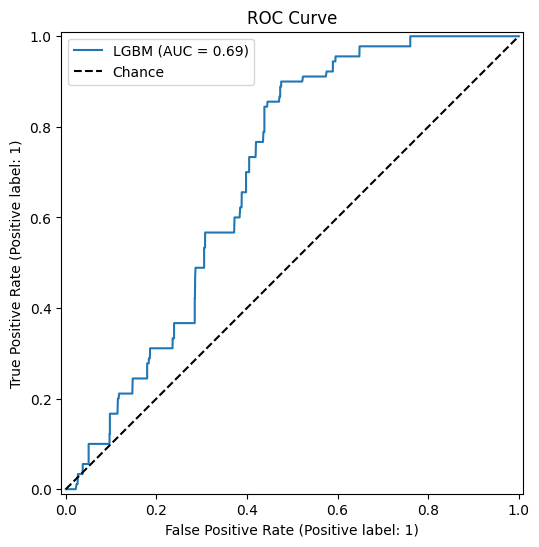

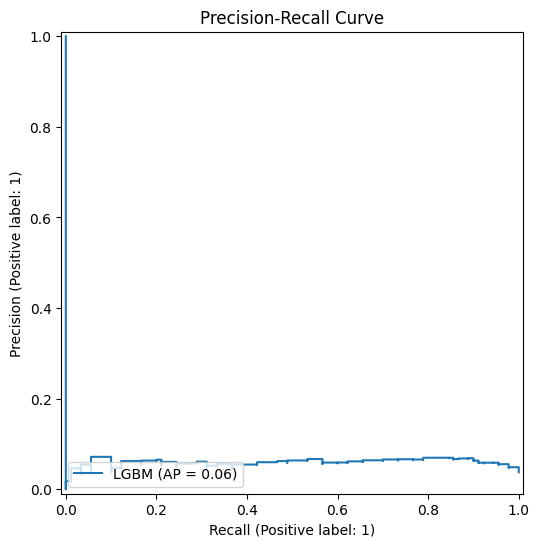

[2025-04-09 21:42:15] [INFO] ModelTrainingLoggerFL - Top Feature Importances:
Precip_lag6             458
Precip_lag1             397
Spec Humid_lag6         281
Sea Level Press_lag1    268
Sea Level Press_lag6    249
Sea Level Press_lag3    248
Sea Level Press         248
Precip                  241
Sens Heat Flux_lag6     222
Soil Moisture_lag1      212
Spec Humid              209
Spec Humid_lag1         205
Soil Moisture_lag3      202
Soil Moisture_lag6      199
Max Temp_lag6           187
Wind Speed              181
Sens Heat Flux          176
Max Temp_lag3           175
Soil Moisture           172
Wind Speed_lag6         169



Top 20 Features:
Precip_lag6             458
Precip_lag1             397
Spec Humid_lag6         281
Sea Level Press_lag1    268
Sea Level Press_lag6    249
Sea Level Press_lag3    248
Sea Level Press         248
Precip                  241
Sens Heat Flux_lag6     222
Soil Moisture_lag1      212
Spec Humid              209
Spec Humid_lag1         205
Soil Moisture_lag3      202
Soil Moisture_lag6      199
Max Temp_lag6           187
Wind Speed              181
Sens Heat Flux          176
Max Temp_lag3           175
Soil Moisture           172
Wind Speed_lag6         169
dtype: int32


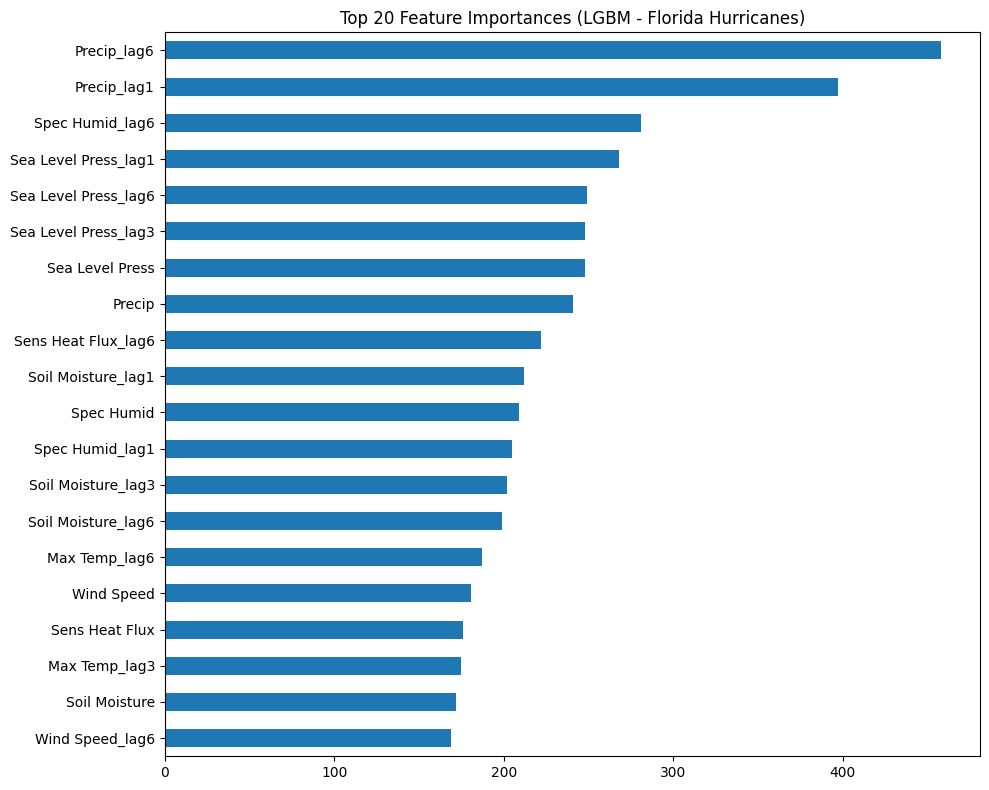

[2025-04-09 21:42:15] [INFO] ModelTrainingLoggerFL - --- Model Training and Evaluation Complete ---


In [54]:
# --- Cell 10: Evaluate Model ---
logger.info("Evaluating model on the test set...")
try:
    if 'lgbm_clf' not in locals() or lgbm_clf is None:
        # Try loading if not trained in this session
        logger.info(f"Model object 'lgbm_clf' not found in memory, attempting to load from {MODEL_PATH}")
        if os.path.exists(MODEL_PATH):
             lgbm_clf = joblib.load(MODEL_PATH)
             logger.info("Model loaded successfully.")
        else:
             raise FileNotFoundError(f"Model file not found at {MODEL_PATH} and model not trained in session.")

    if 'X_test_scaled' not in locals() or 'y_test' not in locals():
         raise NameError("Scaled test data (X_test_scaled, y_test) not defined.")

    # Check if test set is empty (if TEST_YEAR_START was out of range)
    if X_test_scaled.shape[0] == 0:
         logger.warning("Test set is empty. Skipping evaluation.")
    else:
        # --- Make Predictions ---
        model_to_eval = lgbm_clf
        y_pred_proba = model_to_eval.predict_proba(X_test_scaled)[:, 1] # Probability of class 1
        y_pred_class = model_to_eval.predict(X_test_scaled) # Class prediction (default 0.5 threshold)

        # --- Calculate Metrics ---
        # Check if y_test has both classes before calculating metrics that require it
        if y_test.nunique() < 2:
             logger.warning("Test set contains only one class. Cannot calculate AUC ROC/PR or full classification report.")
             auc_score = np.nan
             pr_auc = np.nan
             report = "N/A (Only one class in y_test)"
        else:
            auc_score = roc_auc_score(y_test, y_pred_proba)
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            pr_auc = auc(recall, precision)
            report = classification_report(y_test, y_pred_class, zero_division=0)

        logger.info(f"\n--- Evaluation Results ({TARGET_EVENT_TYPE} - Florida) ---")
        logger.info(f"AUC Score: {auc_score:.4f}")
        logger.info(f"AUC-PR Score: {pr_auc:.4f}")
        logger.info(f"Classification Report (Threshold 0.5):\n{report}")

        print(f"\n--- Evaluation Results ({TARGET_EVENT_TYPE} - Florida) ---")
        print(f"AUC Score: {auc_score:.4f}")
        print(f"AUC-PR Score: {pr_auc:.4f}")
        print("\nClassification Report (Threshold 0.5):")
        print(report)

        # --- Plotting ---
        if y_test.nunique() >= 2:
            # ROC Curve
            plt.figure(figsize=(8, 6))
            from sklearn.metrics import RocCurveDisplay
            RocCurveDisplay.from_predictions(y_test, y_pred_proba, name='LGBM', ax=plt.gca())
            plt.plot([0, 1], [0, 1], 'k--', label='Chance')
            plt.title('ROC Curve')
            plt.legend()
            plt.savefig(os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_FL_roc_curve.png"))
            plt.show()

            # Precision-Recall Curve
            plt.figure(figsize=(8, 6))
            from sklearn.metrics import PrecisionRecallDisplay
            PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name='LGBM', ax=plt.gca())
            plt.title('Precision-Recall Curve')
            plt.savefig(os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_FL_pr_curve.png"))
            plt.show()

        # Feature Importances
        if hasattr(model_to_eval, 'feature_importances_'):
             # Need feature names from training step
             if 'feature_cols' not in locals():
                 logger.warning("Feature names not found, cannot display feature importances with labels.")
                 # Get importances without names
                 importances_values = model_to_eval.feature_importances_
                 print("\nFeature Importances (indices only):")
                 print(np.argsort(importances_values)[::-1]) # Print indices of most important
             else:
                 importances = pd.Series(model_to_eval.feature_importances_, index=feature_cols).sort_values(ascending=False)
                 logger.info(f"Top Feature Importances:\n{importances.head(20).to_string()}")
                 print("\nTop 20 Features:")
                 print(importances.head(20))
                 # Plot
                 plt.figure(figsize=(10, 8))
                 importances.head(20).plot(kind='barh')
                 plt.title("Top 20 Feature Importances (LGBM - Florida Hurricanes)")
                 plt.gca().invert_yaxis()
                 plt.tight_layout()
                 plt.savefig(os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_FL_feature_importance.png"))
                 plt.show()

except NameError as ne:
     logger.exception(f"Missing variable for evaluation: {ne}")
     raise ne
except FileNotFoundError as fe:
     logger.exception(f"Model or scaler file not found for evaluation: {fe}")
     raise fe
except Exception as e:
     logger.exception(f"Failed during model evaluation: {e}")
     raise e

logger.info("--- Model Training and Evaluation Complete ---")

[2025-04-09 21:42:15] [INFO] ModelTrainingLoggerFL - Evaluating model's ability to predict statewide monthly expected hits (sum of probabilities)...
c:\Users\60864\Desktop\PycharmProjects\storm\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[2025-04-09 21:42:15] [INFO] ModelTrainingLoggerFL - Monthly counts/sums calculated.



--- Comparison of Actual County Hits vs. Predicted Expected Hits (Test Set) ---


,YearMonth,actual_county_hits,predicted_expected_hits,time
5,2022-06,8,0.005467,2022-06-01
8,2022-09,16,19.952423,2022-09-01
10,2022-11,25,0.012587,2022-11-01
19,2023-08,9,7.886586,2023-08-01
31,2024-08,13,0.549461,2024-08-01
32,2024-09,9,5.157799,2024-09-01
33,2024-10,10,0.027985,2024-10-01



--- Months with Highest Predicted Expected Hits ---


,YearMonth,actual_county_hits,predicted_expected_hits,time
8,2022-09,16,19.952423,2022-09-01
17,2023-06,0,9.968962,2023-06-01
19,2023-08,9,7.886586,2023-08-01
20,2023-09,0,7.415034,2023-09-01
32,2024-09,9,5.157799,2024-09-01
18,2023-07,0,4.105913,2023-07-01
6,2022-07,0,2.383208,2022-07-01
9,2022-10,0,1.570070,2022-10-01
7,2022-08,0,1.180823,2022-08-01
31,2024-08,13,0.549461,2024-08-01


[2025-04-09 21:42:15] [INFO] ModelTrainingLoggerFL - Statewide Monthly Expected Hit Prediction Performance:
[2025-04-09 21:42:15] [INFO] ModelTrainingLoggerFL -   Mean Absolute Error (MAE): 2.5511
[2025-04-09 21:42:15] [INFO] ModelTrainingLoggerFL -   Correlation: 0.3618
[2025-04-09 21:42:15] [INFO] ModelTrainingLoggerFL -   R-squared: -0.0037



Statewide Monthly Expected Hit Prediction Performance:
  Mean Absolute Error (MAE): 2.5511 (Avg difference between actual count and expected count)
  Correlation: 0.3618
  R-squared: -0.0037


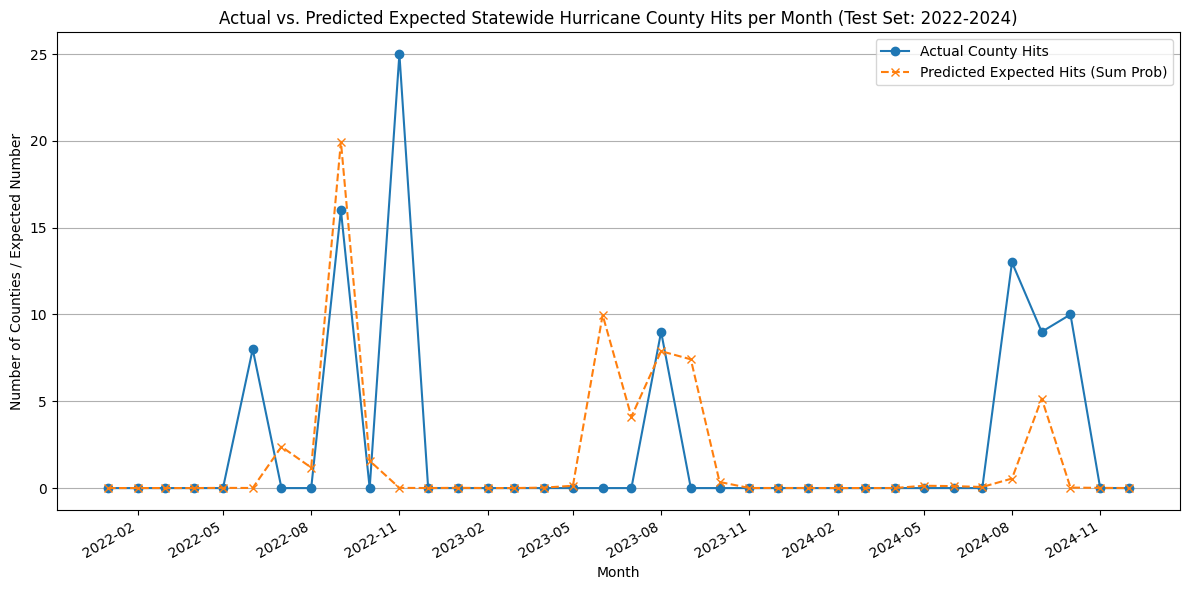

[2025-04-09 21:42:15] [INFO] ModelTrainingLoggerFL - --- Statewide Monthly Expected Hit Evaluation Complete ---


In [55]:
# --- Cell 11: Evaluate Statewide Expected Monthly Hits (Sum of Probabilities) ---

logger.info("Evaluating model's ability to predict statewide monthly expected hits (sum of probabilities)...")

try:
    # --- Check required variables exist ---
    if 'lgbm_clf' not in locals() or lgbm_clf is None: raise NameError("Trained model 'lgbm_clf' not found.")
    if 'X_test_scaled' not in locals() or 'y_test' not in locals() or 'test_identifiers' not in locals():
        raise NameError("Test data (X_test_scaled, y_test, test_identifiers) not found.")
    if X_test_scaled.shape[0] == 0 or y_test.empty or test_identifiers.empty:
        logger.warning("Test set is empty. Skipping statewide evaluation.")
        raise ValueError("Test set empty, cannot evaluate.") # Or skip cell

    # --- Get Predicted Probabilities ---
    logger.debug("Predicting probabilities for the test set...")
    pred_proba = lgbm_clf.predict_proba(X_test_scaled)[:, 1] # Probability of class 1 (hurricane occurred)

    # --- Combine with Identifiers ---
    logger.debug("Combining probabilities with county and time information...")
    df_test_results = test_identifiers.copy()
    # Ensure indices align
    df_test_results.reset_index(drop=True, inplace=True)
    df_test_results['actual_occurred'] = y_test.values
    df_test_results['predicted_proba'] = pred_proba
    # Note: We don't need the binary 'predicted_occurred' column anymore for this approach

    # --- Calculate Monthly Counts / Sums ---
    logger.debug("Calculating actual counts and predicted expected hits (sum of probabilities) per month...")
    df_test_results['time'] = pd.to_datetime(df_test_results['time'])
    df_test_results['YearMonth'] = df_test_results['time'].dt.to_period('M')

    # Actual counts (sum of binary 0/1)
    actual_monthly_counts = df_test_results.groupby('YearMonth')['actual_occurred'].sum().reset_index()
    actual_monthly_counts.rename(columns={'actual_occurred': 'actual_county_hits'}, inplace=True)

    # Predicted Expected counts (sum of probabilities)
    predicted_monthly_expected = df_test_results.groupby('YearMonth')['predicted_proba'].sum().reset_index()
    predicted_monthly_expected.rename(columns={'predicted_proba': 'predicted_expected_hits'}, inplace=True)

    # Merge actual and predicted
    df_monthly_compare = pd.merge(actual_monthly_counts, predicted_monthly_expected, on='YearMonth', how='outer').fillna(0)
    df_monthly_compare['time'] = df_monthly_compare['YearMonth'].dt.to_timestamp()

    logger.info("Monthly counts/sums calculated.")
    print("\n--- Comparison of Actual County Hits vs. Predicted Expected Hits (Test Set) ---")
    # Display months where actual hits > 0 to see relevant months
    display(df_monthly_compare[ df_monthly_compare['actual_county_hits'] > 0 ].sort_values('YearMonth'))
    # Also display months with highest predicted expected hits
    print("\n--- Months with Highest Predicted Expected Hits ---")
    display(df_monthly_compare.nlargest(10, 'predicted_expected_hits'))


    # --- Evaluate the Match ---
    from sklearn.metrics import mean_absolute_error, r2_score
    # Compare actual integer counts vs predicted expected float counts
    mae = mean_absolute_error(df_monthly_compare['actual_county_hits'], df_monthly_compare['predicted_expected_hits'])
    correlation = df_monthly_compare['actual_county_hits'].corr(df_monthly_compare['predicted_expected_hits'])
    try: # R-squared might be more meaningful here as expected value tries to approximate mean
        r2 = r2_score(df_monthly_compare['actual_county_hits'], df_monthly_compare['predicted_expected_hits'])
    except ValueError: r2 = np.nan

    logger.info(f"Statewide Monthly Expected Hit Prediction Performance:")
    logger.info(f"  Mean Absolute Error (MAE): {mae:.4f}")
    logger.info(f"  Correlation: {correlation:.4f}")
    logger.info(f"  R-squared: {r2:.4f}")

    print(f"\nStatewide Monthly Expected Hit Prediction Performance:")
    print(f"  Mean Absolute Error (MAE): {mae:.4f} (Avg difference between actual count and expected count)")
    print(f"  Correlation: {correlation:.4f}")
    print(f"  R-squared: {r2:.4f}")


    # --- Plot Comparison ---
    plt.figure(figsize=(12, 6))
    plt.plot(df_monthly_compare['time'], df_monthly_compare['actual_county_hits'], label='Actual County Hits', marker='o', linestyle='-', markersize=6)
    plt.plot(df_monthly_compare['time'], df_monthly_compare['predicted_expected_hits'], label='Predicted Expected Hits (Sum Prob)', marker='x', linestyle='--', markersize=6)
    plt.xlabel("Month")
    plt.ylabel("Number of Counties / Expected Number")
    plt.title("Actual vs. Predicted Expected Statewide Hurricane County Hits per Month (Test Set: 2022-2024)")
    plt.legend()
    plt.grid(True, axis='y')
    # Improve date formatting
    import matplotlib.dates as mdates
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_FL_statewide_expected_hits_comparison.png")) # New filename
    plt.show()

except NameError as ne:
    logger.exception(f"Missing variable for statewide evaluation: {ne}")
except ValueError as ve:
    logger.exception(f"ValueError during statewide evaluation: {ve}")
except Exception as e:
    logger.exception(f"An unexpected error occurred during statewide evaluation: {e}")

logger.info("--- Statewide Monthly Expected Hit Evaluation Complete ---")